In [1]:
import sys

sys.path.append('/home/lumargot/hysterectomy-coach/src/py')

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
import pytorch_lightning as pl
from torchvision import transforms
import cv2
import imageio
import random

import monai
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import SimpleITK as sitk
import matplotlib.pyplot as plt
from utils import *
from visualization import *
from nets.segmentation import MaskRCNN
from loaders.hyst_dataset import HystDataModuleSeg, BBXImageTestTransform, BBXImageTrainTransform, BBXImageEvalTransform
from matplotlib.patches import Rectangle

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [ ]:
def remove_labels(df):
    concats = ['Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Laparoscopic Scissors', 'Laparoscopic Suction', 'Robot Scissors', 'monopolarhook' ]

    if concats is not None:
        replacement_val =20 # df.loc[ df['Instrument Name'] == concats[0]]['class'].unique()
        df.loc[ df['Instrument Name'].isin(concats), "class" ] = replacement_val

    unique_classes = sorted(df['class'].unique())
    class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}

    df['class'] = df['class'].map(class_mapping)
    df.rename(columns={concats[0]: 'Others'})
    return df.reset_index()

In [ ]:
class_names = ['Background', 'Laparoscopic Grasper', 'Laparoscopic Needle Driver', 'Needle', 'Robot Needle Driver', 'Robot Grasper','Other']

df_test = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_test.csv')
df_test = remove_labels(df_test)
 

print(df_test[['Instrument Name', 'class']].value_counts())
class_column = 'class'
mount_point = '/MEDUSA_STOR/jprieto/surgery_tracking/'
img_column = 'img_path'
seg_column = 'seg_path'

      class
0         5
1         4
2         6
1005      1
1006      2
1671      3
Instrument Name             class
Needle                      3        12628
Laparoscopic Grasper        1         7608
Laparoscopic Needle Driver  2         6949
Robot Needle Driver         4         5715
Bipolar                     6         5464
Robot Grasper               5         3640
Robot Grasper Heat          6          389
Laparoscopic Scissors       6          187
Laparoscopic Suction        6           12
dtype: int64


In [ ]:
ttdata = HystDataModuleSeg( df_test, df_test, df_test, batch_size=50, num_workers=1, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mount_point,train_transform=BBXImageTrainTransform(),valid_transform=BBXImageEvalTransform(), 
                            test_transform=BBXImageTestTransform())

ttdata.setup()

test_dl = ttdata.test_dataloader()
test_ds = ttdata.test_ds

ckpt = '/MEDUSA_STOR/jprieto/surgery_tracking/output/freeze/2nd/epoch=20-val_loss=3.82.ckpt'
model = MaskRCNN.load_from_checkpoint(ckpt)
    
model.eval()
model.cuda()

MaskRCNN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): 

In [9]:
batch = test_ds[0]
imgs, targets = [],[]
img = batch.pop('img', None)

batch['boxes'] = ttdata.compute_bb_mask(batch['masks'], pad=0.01)


batch['boxes'] = batch['boxes'].cuda()
batch['masks'] = batch['masks'].cuda()
batch['labels'] = batch['labels'].cuda()

imgs.append(img.unsqueeze(0))
targets.append(batch)
imgs = torch.cat(imgs)

In [ ]:
data_out = []
with torch.no_grad():
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)): 
        if idx == 32:
        
            imgs = []
            img, batch = batch

            imgs.append(img)
            imgs = torch.cat(imgs)

            outputs = model.forward(imgs.cuda(), mode='test')
            SCORE_THR = 0.2

            pred_boxes = outputs[0]['boxes'].cpu().detach().numpy()
            pred_masks = outputs[0]['masks'].cpu().detach().numpy()
            pred_labels = outputs[0]['labels'].cpu().detach().numpy()
            pred_scores = outputs[0]['scores'].cpu().detach().numpy()

            gt_masks = batch[0]['masks']
            gt_boxes = ttdata.compute_bb_mask(gt_masks, pad=0.01).numpy()
            gt_labels = batch[0]['labels'].cpu().detach().numpy()


            if (pred_scores >=SCORE_THR).any():
                refined_labels, refined_scores, refined_masks, refined_boxes = filter_by_confidence(pred_labels, pred_scores, pred_masks, pred_boxes, thr=SCORE_THR)
                refined_masks[refined_masks>0.2] = 1

            break

 10%|█         | 32/316 [43:07<6:22:43, 80.86s/it]  


Laparoscopic Needle Driver None
Laparoscopic Grasper None


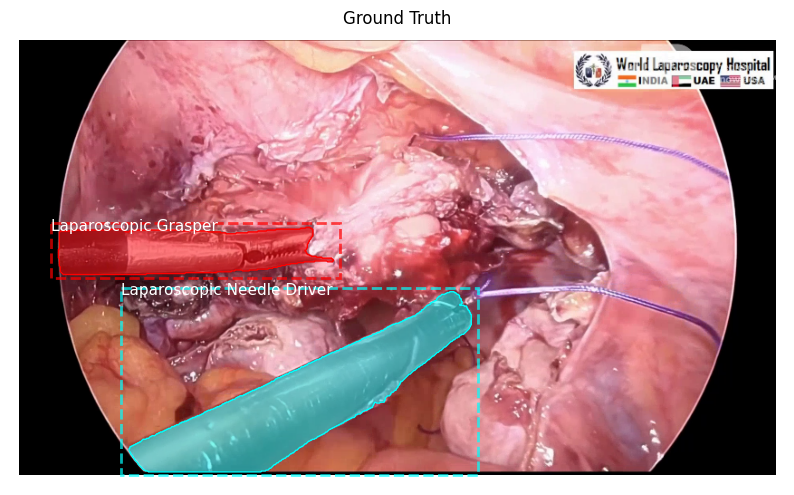

In [61]:
## ground truth 

display_instances(image=255*imgs[0].permute(1,2,0).numpy(), 
                  boxes=gt_boxes[:, [1, 0, 3, 2]], 
                  masks=gt_masks.permute(1,2,0).numpy(),
                  class_ids=gt_labels, 
                  class_names=class_names,
                  figsize = (10,10),
                  title='Ground Truth',
                  show_mask = True)

Other 0.56389666
Robot Grasper 0.15324673


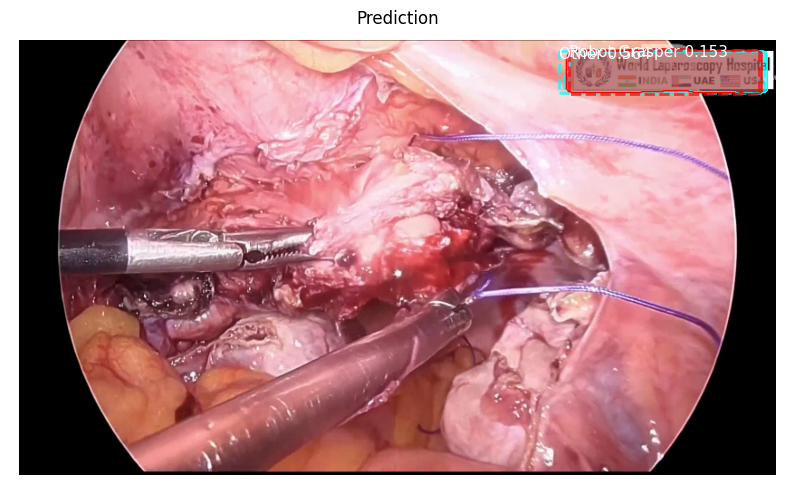

In [66]:

display_instances(image=255*imgs[0].permute(1,2,0).numpy(), 
                  boxes=refined_boxes[:, [1, 0, 3, 2]], 
                  masks=refined_masks[:,0,:,:].transpose(1,2,0), 
                  class_ids=refined_labels, 
                  class_names=class_names, scores=refined_scores, 
                  show_mask = True, show_bbox=True,
                  title='Prediction',
                  figsize = (10,10),)